# per-line transcription with LLM & OCR

In [149]:
from openai import OpenAI
import os
import re
import pandas as pd
from dotenv import load_dotenv
import requests
import base64
import subprocess
from IPython.display import display, Image
from PIL import Image as PILImage

In [150]:
import cv2
import easyocr
import matplotlib.pyplot as plt
import pytesseract
import keras_ocr

In [151]:
path = os.path.dirname(os.getcwd()) # Parent directory
image_folder = path+'/data/lines'

In [152]:
# OpenAI
load_dotenv() #get the environment 
openai_API_KEY = os.getenv("OPENAI_API_KEY")
openai_client = OpenAI(api_key=openai_API_KEY)

## Read and encode the images

In [153]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [154]:
images = []
for image in os.listdir(image_folder):
    if image.endswith('.jpg'):
        images.append(image)

rows = []
for image in images:
    name = image.split('.')[0]
    name_split = name.split('_')[0]
    file_name = name_split.split('example')[1]
    line_name = name.split('_')[1]
    encoded_value = encode_image(image_folder+'/'+image)
    rows.append({'file': file_name, 'line': line_name, 'encoded': encoded_value})


In [155]:
images_encoded = pd.DataFrame(rows)
images_encoded

,file,line,encoded
0,6,02,/9j/4QYmRXhpZgAATU0AKgAAAAgADAEAAAMAAAABFkAAAA...
1,8,07,/9j/4QZ2RXhpZgAATU0AKgAAAAgADAEAAAMAAAABFkAAAA...
2,8,13,/9j/4QVvRXhpZgAATU0AKgAAAAgADAEAAAMAAAABFkAAAA...
3,15,03,/9j/4QU0RXhpZgAATU0AKgAAAAgADAEAAAMAAAABFkAAAA...
4,4,13,/9j/4QXKRXhpZgAATU0AKgAAAAgADAEAAAMAAAABFkAAAA...
...,...,...,...
278,3,03,/9j/4QYtRXhpZgAATU0AKgAAAAgADAEAAAMAAAABFkAAAA...
279,12,13,/9j/4QYbRXhpZgAATU0AKgAAAAgADAEAAAMAAAABFkAAAA...
280,12,07,/9j/4QZHRXhpZgAATU0AKgAAAAgADAEAAAMAAAABFkAAAA...
281,1,12,/9j/4QVrRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...


In [156]:
images_encoded['file'] = images_encoded['file'].astype('int')
images_encoded = images_encoded.sort_values(by=['file', 'line'])
images_encoded = images_encoded.reset_index(drop=True)
images_encoded.head(30)

,file,line,encoded
0,1,00,/9j/4QczRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...
1,1,01,/9j/4QZBRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...
2,1,02,/9j/4QX5RXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...
3,1,03,/9j/4QYvRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...
4,1,04,/9j/4QZLRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...
5,1,05,/9j/4QVaRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...
6,1,06,/9j/4QVqRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...
7,1,07,/9j/4QX5RXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...
8,1,08,/9j/4QWRRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...
9,1,09,/9j/4QZyRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...


## Zero-shot llm

In [157]:
prompt = """
    Recognize the text from the image:
    ```plaintext
"""


# I didn't consider the header.. I'm unsure whether we need to include in the analysis.
prompt_complex = """
    Recognize the text from the image:
    
    Tips:
    It's an old Belgian document written in French.
    Unless the text starts with "Arrêté le \d{2} \w+ \d{4}( \w+)? servais" or some cells contain notes, each cell in the image usually contains the following information
    - Number / date / Family Name/ First Name/ Location/ Date/ One or more full names. Often ends with "& autres"/number/ number/number/number/number with a year/ number with a year/ date/date/number/date/number
"""

In [158]:
def callOpenAI(prompt, max_tokens=800, base64_image=None):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai_API_KEY}"
    } 
    model_vision = "gpt-4o"
    payload = {
        "model": model_vision, # only gpt-4o can handle images
        "messages": [
        {
            "role": "user",
            "content": [
            {
                "type": "text",
                "text": prompt
            },
            {
                "type": "image_url",
                "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
                }
            }
            ]
        }
        ],
        "max_tokens": max_tokens,
        "temperature": 0
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    try:
        return response.json()["choices"][0]["message"]["content"]
    except:
        print(response.json()["error"]["message"])

In [159]:
def callPostProcessing(max_tokens=800, prompt_parameter = None):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai_API_KEY}"
    } 
    payload = {
        "model": "gpt-4o",
        "messages": [
        {
            "role": "user",
            "content": [
            {
                "type": "text",
                "text": f"""This is an output from you. Clean it such that we only have the table without any separators, no comment from you: {prompt_parameter}
                """
            }
            ]
        }
        ],
        "max_tokens": max_tokens,
        "temperature": 0
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    try:
        return response.json()["choices"][0]["message"]["content"]
    except:
        print(response.json()["error"]["message"])


In [160]:
test = callOpenAI(prompt=prompt, max_tokens=800, base64_image = images_encoded[(images_encoded['file']==1) & (images_encoded['line']== '01')].encoded.values[0])

In [161]:
print(test)

The text in the image appears to be:

"Societé le vingt huit octobre 1919"


In [162]:
test_complex = callOpenAI(prompt=prompt_complex, max_tokens=800, base64_image = images_encoded[(images_encoded['file']==1) & (images_encoded['line']== '01')].encoded.values[0])
print(test_complex)

The text in the image reads:

"Arrêté le vingt huit octobre 1919 servais"


In [163]:
test_path = image_folder+'/example1_01.jpg'

## EasyOCR

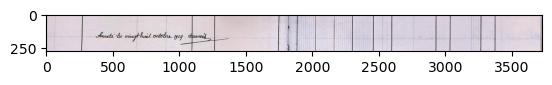

In [148]:
test_image = cv2.imread(test_path)
plt.imshow(test_image)

In [164]:
def easyOCR(image_path):
    reader = easyocr.Reader(['fr'])
    img = cv2.imread(image_path)
    results = reader.readtext(img)
    output = []
    for res in results:
        det, conf = res[1], res[2]
        output.append((det, round(conf, 2))) 
    text = ' '.join([i[0] for i in output])
    return text

In [165]:
test_ocr = easyOCR(test_path)

In [166]:
test_ocr

'~Bcrta` 8 oetolz 1919 d4earuey vicytAul'

### Pytesseract

In [167]:
def pytesseractOCR(image_path):
    try:
        image = Image.open(image_path)
        text = pytesseract.image_to_string(image)
        return text
    except:
        print("[ERROR] pytesseractOCR failed! (should be installed)")
        return ""

In [168]:
test_pytesseract = pytesseractOCR(image_path=test_path)
print(test_pytesseract)

[ERROR] pytesseractOCR failed! (should be installed)



### Keras

Not good for non-english?

In [172]:
def kerasOCR(image_path):
    pipeline = keras_ocr.pipeline.Pipeline()
    image = keras_ocr.tools.read(image_path)
    prediction_groups = pipeline.recognize([image])
    words = []
    for line in prediction_groups[0]:
        for word in line:
            try:
                if isinstance(word[0], str):
                    words.append(word[0])
            except IndexError:
                continue
    text = ' '.join(words)
    return text

In [173]:
test_keras = kerasOCR(image_path=test_path)
print(test_keras)

Looking for /Users/serenekim/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.
Looking for /Users/serenekim/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 1s 751ms/step
d r p o a g


# Pipeline

In [113]:
gpt4o_texts = []
easyOCR_texts = []
# pytesseract_texts = []
# kerasOCR_texts = []

# for file in images_encoded['file'].unique():
for file in [1]:
    print(f"File: {file}")
    for line in images_encoded[images_encoded['file'] == file]['line']:
        print(f"Line: {line}")
        image_path = image_folder+f'/example{file}_{line}.jpg'
        input_encoded_image = images_encoded[(images_encoded['file'] == file) & (images_encoded['line'] == line) ]['encoded'].values[0]
        
###### GPT-4o
        line_text_gpt4o = callOpenAI(prompt=prompt, max_tokens=800, base64_image = input_encoded_image)
        # print(f"OpenAI: {line_text_gpt4o}")
        postprocessed_gpt40_text = callPostProcessing(max_tokens=800, prompt_parameter = line_text_gpt4o)
        gpt4o_texts.append({'file': file, 'line': line, 'gpt4o_text': postprocessed_gpt40_text})
        line_text_complex = callOpenAI(prompt=prompt_complex, max_tokens=800, base64_image = input_encoded_image)
        print(f"OpenAI Complex: {line_text_complex}")

###### EasyOCR
        line_text_easyOCR = easyOCR(image_path)
    # Question: Will I need to postprocess the EasyOCR text?
        easyOCR_texts.append({'file': file, 'line': line, 'easyOCR_text': line_text_easyOCR})
        # print(f"EasyOCR: {line_text_easyOCR}")

###### Pytesseract
        # line_text_pytesseract = pytesseractOCR(image_path)
        # print(f"Pytesseract: {line_text_pytesseract}")

###### KerasOCR
        # line_text_keras = kerasOCR(image_path)
        # kerasOCR_texts.append({'file': file, 'line': line, 'kerasOCR_text': line_text_keras})
        # print(f"KerasOCR: {line_text_keras}")

gpt4o_texts_df = pd.DataFrame(gpt4o_texts)
easyOCR_texts_df = pd.DataFrame(easyOCR_texts)

File: 1
Line: 00
OpenAI Complex: Here is the transcribed text from the image:

```
N° d'ordre (1) | DATE DU DÉPÔT des DÉCLARATIONS. | DÉSIGNATION DES PERSONNES DÉCÉDÉES, OU ABSENTES. | DATE DU DÉCÈS ou du JUGEMENT D'ENVOI en possession, en cas d'absence. | NOMS, PRÉNOMS ET DEMEURES DES PARTIES DÉCLARANTES. | DROITS DE SUCCESSION EN LIGNE COLLATERALE et de MUTATION EN LIGNE DIRECTE. | DROIT DE MUTATION par décès. | NUMÉROS des DÉCLARATIONS | DATE de l'exigibilité des droits. | NUMÉROS de la consignation des droits au somnier n° 25. | RECETTE des DROITS ET AMENDES. | DATE | N° | CAUTIONNEMENTS. NUMÉROS de la consignation au somnier n° 30. | OBSERVATIONS. (Les déclarations qui figurent à l'état n° 11 doivent être énoncées en exécution, dans la présente colonne.)
```

This transcription captures the headers of the columns in the document.
Line: 01
OpenAI Complex: The text in the image reads:

"Arrêté le vingt huit octobre 1919 servais"
Line: 02
OpenAI Complex: The text in the image reads:


In [114]:
gpt4o_texts_df

,file,line,gpt4o_text
0,1,00,N° d'ordre\nDATE DU DÉPÔT des DÉCLARATIONS\nDÉ...
1,1,01,Societé le vingt huit octobre 1919
2,1,02,Arrêté le vingt neuf octobre 1919 Servais
3,1,03,398 treinte octubre Herrero Alphonse Opheim 29...
4,1,04,398½ d Lefèvre Jules Brulé-L. 8 janvier ...
5,1,05,Avant le trente octobre 1919
6,1,06,Soresti le trent un octob 1929 Servais
7,1,07,Sorreté le premier novembre 1919 Toussaint Ser...
8,1,08,Arresté le deux novembre 1919 Dimanche Servais
9,1,09,```\n399 Crois. 6bre. Desmedt Jeanne Nivelles ...


In [115]:
easyOCR_texts_df

,file,line,easyOCR_text
0,1,00,DÉSIGNATION DES PERSONNES DÉCÉDÉES OU AlSENTES...
1,1,01,~Bcrta` 8 oetolz 1919 d4earuey vicytAul
2,1,02,Jbsucala & veyhmeuf ouoba tg19 [eevœy
3,1,03,891 ta HBevcenk ~Bepkonssjk oj hain Hgoucoal Y...
4,1,04,"TulL Bouuù Q ""Janer ~aobà Bhuile RRXR 26 aplul..."
5,1,05,sueb' Q {cmEE oclb. 1419 dqune
6,1,06,Jsveaki @ bemlL un oelba_-1919 dexl'
7,1,07,kszeté & fummlar nouembas_ 1919 ollsaams Vuser...
8,1,08,Joveal + Jeunx 2ouemba (949 Oùhanebe Fuuunù/
9,1,09,889 644 (esmedk Yenooz Yiveblu 43 m22 euupsek ...
